### Strategy 1

Preprocessing step done by running: `python chmt_preproc/main.py --data-path proj_data/ --out-path preproc_data/`

Generates csv file for each subject, Additionaly we get path_file.csv that contains a summary with information to access each subject dataset.

In [96]:
import numpy as np
import pandas as pd
from scipy.signal import welch

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.2)

read summary of dataset

In [138]:
data_pre = pd.read_csv('preproc_data/path_file.csv')

In [139]:
data_pre.head()

fn  target dataset_name  sfreq  \
0  b906373005ba09e6.csv  trauma       trauma    125   
1  bdcff4b8f633033a.csv  trauma       trauma    125   
2  521a5a6f578df78a.csv  trauma       trauma    125   
3  bc8568311c86157d.csv  trauma       trauma    125   
4  5c9ca89c610ef553.csv  trauma       trauma    125   

                                            channels  n_channels  \
0  A1|A2|C3|C4|Cz|F3|F4|F7|F8|Fp1|Fp2|Fz|O1|O2|P3...          21   
1  EEG A1-N|EEG A2-A1|EEG C3-A1|EEG C4-A1|EEG Cz-...          30   
2  EEG A1-N|EEG A2-A1|EEG C3-A1|EEG C4-A1|EEG Cz-...          30   
3  EEG A1|EEG A2|EEG C3|EEG C4|EEG Cb1|EEG Cz|EEG...          24   
4  EEG A1-N|EEG A2-A1|EEG C3-A1|EEG C4-A1|EEG Cz-...          27   

                                        channels_eeg  n_channels_eeg  seconds  
0                                                NaN               0    238.0  
1  EEG A1-N|EEG A2-A1|EEG C3-A1|EEG C4-A1|EEG Cz-...              21     32.0  
2  EEG A1-N|EEG A2-A1|EEG C3-A1|EEG C4-A1|EEG Cz-...              21     57.0  
3  EEG A1|EEG A2|EEG C3|EEG C4|EEG Cb1|EEG Cz|EEG...              24    166.0  
4  EEG A1-N|EEG A2-A1|EEG C3-A1|EEG C4-A1|EEG Cz-...              21     69.0

In [140]:
# Remove 'cz' column
import tqdm as tqdm

for i in tqdm.trange(data_pre.shape[0]):
    rec = pd.read_csv('preproc_data/{}'.format(data_pre.fn[i]))
    rec = rec.drop('cz', axis=1)
    rec.to_csv('preproc_data/{}'.format(data_pre.fn[i]), index=False)

100%|██████████| 228/228 [02:27<00:00,  1.55it/s]


In [144]:
# first strategy
def get_extracts(file_names, targets, sfreqs):
    """
    Args:
    file_names = [fn1.csv, fn2.csv, ...]
    targets = ['trauma', 'healthy', ...]
    sfreqs = [freq1, freq2, ...]
    
    #records = [np.array[n_samples, n_channels], np.array, np.array, ..]
    
    Return:
    records = []
    """
    subjects = []
    records = []
    targets_chunk = []
    for fn, target, sfreq in zip(file_names, targets, sfreqs):
        record = pd.read_csv(f'preproc_data/{fn}')
        if len(record) < 60 * sfreq:
            continue
        records.append(record[:60*sfreq])
        targets_chunk.append(target)
        subjects.append(fn)
        
    return records, targets_chunk, subjects


In [145]:
fns = data_pre['fn']
targets = data_pre['target']
sfreqs = data_pre['sfreq']

In [146]:
records, targets, subjects = get_extracts(fns, targets, sfreqs)

In [149]:
len(records), len(targets)

(185, 185)

For strategy one we get 185 subjects to analyze

#### Features construction

First let's see the raw signals from different channels for some random subjects

In [148]:
records[20].head()

time        fp1       fp2        f7         f3         fz        f4  \
0     0   2.242732  5.419165  1.928916  -2.329892  -5.784086 -4.523097   
1     8   6.870101  1.476426  1.399882  -0.710076   0.476928 -3.865594   
2    16  13.003960  1.359983  4.146531   4.694282   9.985937  2.019993   
3    24  16.319438  3.272260  7.953360  10.928953  15.860221  7.150622   
4    32  14.290007  1.028703  8.430594  13.632203  15.367846  5.281752   

          f8        t3        c3         c4         t4        t5        p3  \
0   2.420615  3.961377  1.124861  -1.279839   4.562347  7.971806  8.407634   
1   3.733017  1.193905 -0.686372   4.352129   8.677736  2.774224  3.078873   
2   8.721019  1.961267  0.151444  12.708134  16.739708  1.012643 -2.188651   
3  11.651665  5.127535  3.204786  18.254341  22.268371  3.457988 -5.265813   
4   6.641774  6.587033  5.106537  18.092643  19.835607  4.629078 -7.015975   

         pz         p4         t6        o1        o2  
0  8.355937   5.151509   6.662781  9.864745  8.807678  
1  8.960938   6.507118   9.273965  7.271033  3.774219  
2  7.623592   9.942066  14.365974  4.401106  0.169254  
3  2.619115  13.130582  18.274944  2.695271 -0.191299  
4 -4.203143  13.742218  18.644036  2.107993  0.978300

In [107]:
def plot_rawsignal(time, signal, channel):
    # fig= plt.figure(figsize=(15,4))
    # plt.plot(records[20]['time'], records[20]['t4'])

    # Plot the signal
    fig= plt.figure(figsize=(15,4))
    plt.plot(time, signal, lw=1.5, color='k')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Voltage')
    plt.xlim([time.min(), time.max()])
    plt.title(f'Brain activity, EEG data ({channel})')
    sns.despine()

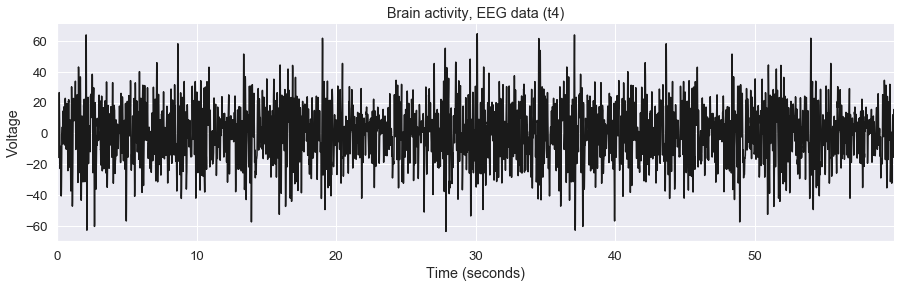

In [106]:
# subject
subject = 20
channel = 't4'
signal = records[subject][channel]

# Define sampling frequency and time vector
sf = 125.
time = np.arange(records[subject].shape[0]) / sf

plot_rawsignal(time, signal, channel)

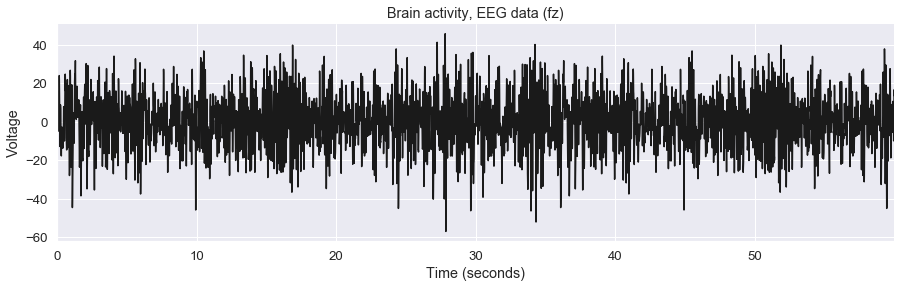

In [109]:
channel = 'fz'
signal = records[subject][channel]
plot_rawsignal(time, signal, channel)

As we can see from the plots above, we can't say something meaningful about the signal.

Let's see more meaningful pictures.

In [115]:
targets[20]

'trauma'

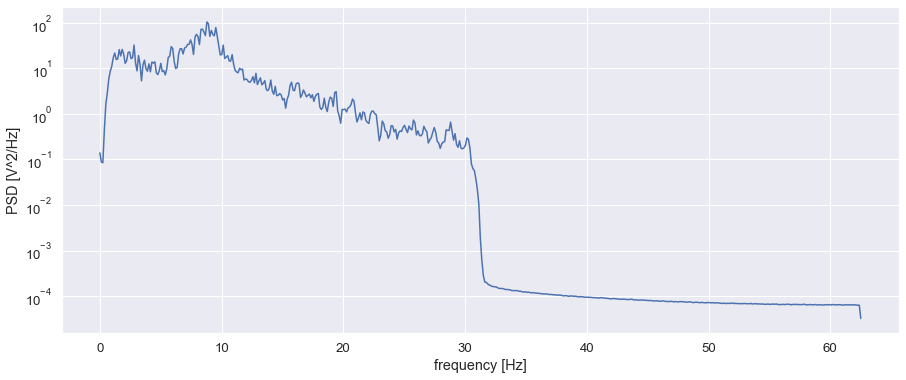

In [113]:
freqs, psd = welch(records[subject]['t4'], fs=125, nperseg=1024)

fig = plt.figure(figsize=[15,6])
plt.semilogy(freqs, psd)
#plt.ylim([0, psd.max()])
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V^2/Hz]')
plt.show()

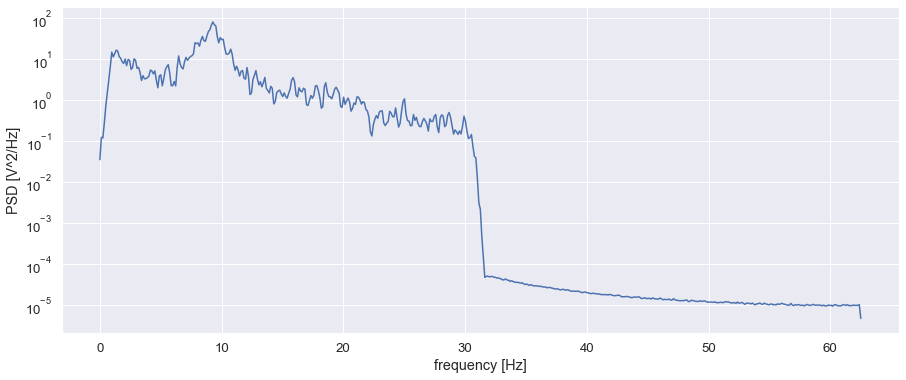

In [112]:
freqs, psd = welch(records[subject]['fz'], fs=125, nperseg=1024)

fig = plt.figure(figsize=[15,6])
plt.semilogy(freqs, psd)
#plt.ylim([0.5e-3, 1])
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V^2/Hz]')
plt.show()

Now let's check for a random healthy subject

In [119]:
subject=150
targets[150]

'healthy'

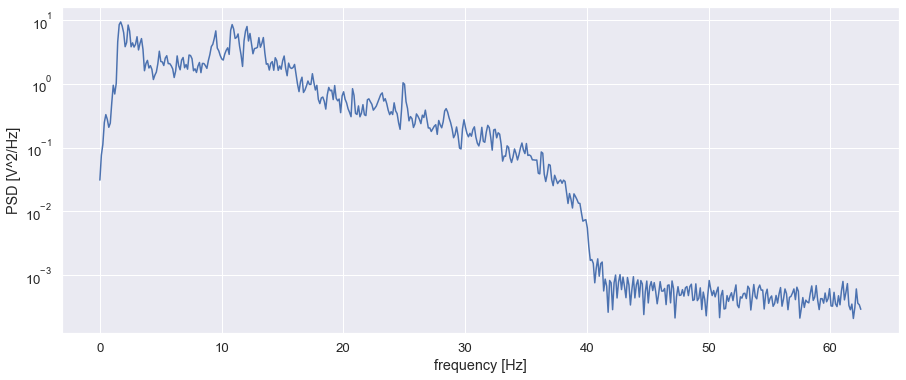

In [122]:
freqs, psd = welch(records[subject]['t4'], fs=125, nperseg=1024)

fig = plt.figure(figsize=[15,6])
plt.semilogy(freqs, psd)
#plt.ylim([0, psd.max()])
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V^2/Hz]')
plt.show()

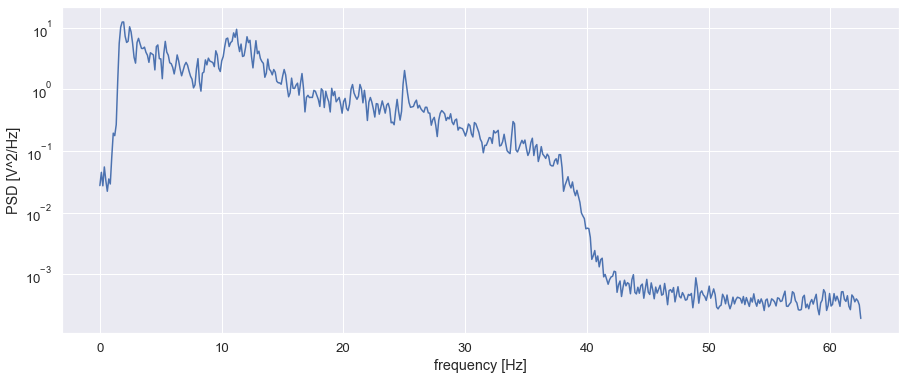

In [121]:
freqs, psd = welch(records[subject]['fz'], fs=125, nperseg=1024)

fig = plt.figure(figsize=[15,6])
plt.semilogy(freqs, psd)
#plt.ylim([0, psd.max()])
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V^2/Hz]')
plt.show()

There seems to be a difference on the PSD on the raw signal for a subject with trauma and a healthy one. In the first case there is huge drop on the psd value for frequencies higher than 30 Hz. In the latter case, however, the drop of psd is smooth and happens for frequencies above 40 Hz.

This difference would suggest the filtering of the signal (for now I would say > 30Hz and < 1Hz)

**Band pass filtering**

can be done with filter function from mne

**Average Band Power**

Next we will try to find a number representing the power contribution of a particular band to the overall power of the signal.

We'll start from this 'prior' as mentioned here (https://www.frontiersin.org/articles/10.3389/fnhum.2015.00011/full)
> mTBI injury is often associated with a decrease in alpha power and an __increase in delta__, beta, and theta bands.


Let's analyze delta band

In [131]:
# Define delta lower and upper limits
low, high = 0.5, 4

# Find intersecting values in frequency vector
idx_delta = np.logical_and(freqs >= low, freqs <= high)

# Plot the power spectral density and fill the delta area
plt.figure(figsize=[15, 6])
plt.plot(freqs, psd, lw=2, color='k')
plt.fill_between(freqs, psd, where=idx_delta, color='skyblue')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power spectral density (uV^2 / Hz)')
plt.xlim([0, 10])
#plt.ylim([0, psd.max() * 1.1])
sns.despine()

In [132]:
from scipy.integrate import simps

# Frequency resolution
freq_res = freqs[1] - freqs[0]  # = 1 / 4 = 0.25

# Compute the absolute power by approximating the area under the curve
delta_power = simps(psd[idx_delta], dx=freq_res)
print('Absolute delta power: %.3f uV^2' % delta_power)

Absolute delta power: 15.933 uV^2


In [133]:
# Relative delta power (expressed as a percentage of total power)
total_power = simps(psd, dx=freq_res)
delta_rel_power = delta_power / total_power
print('Relative delta power: %.3f' % delta_rel_power)

Relative delta power: 0.250


This means that just 25% of the total power is contained in the beta band

**Ratio**

In [134]:
# Thanks to https://raphaelvallat.com/bandpower.html
def bandpower(data, sf, band, window_sec=None, relative=False):
    """Compute the average power of the signal x in a specific frequency band.

    Parameters
    ----------
    data : 1d-array
        Input signal in the time-domain.
    sf : float
        Sampling frequency of the data.
    band : list
        Lower and upper frequencies of the band of interest.
    window_sec : float
        Length of each window in seconds.
        If None, window_sec = (1 / min(band)) * 2
    relative : boolean
        If True, return the relative power (= divided by the total power of the signal).
        If False (default), return the absolute power.

    Return
    ------
    bp : float
        Absolute or relative band power.
    """
    from scipy.signal import welch
    from scipy.integrate import simps
    band = np.asarray(band)
    low, high = band

    # Define window length
    if window_sec is not None:
        nperseg = window_sec * sf
    else:
        nperseg = (2 / low) * sf

    # Compute the modified periodogram (Welch)
    freqs, psd = welch(data, sf, nperseg=nperseg)

    # Frequency resolution
    freq_res = freqs[1] - freqs[0]

    # Find closest indices of band in frequency vector
    idx_band = np.logical_and(freqs >= low, freqs <= high)

    # Integral approximation of the spectrum using Simpson's rule.
    bp = simps(psd[idx_band], dx=freq_res)

    if relative:
        bp /= simps(psd, dx=freq_res)
    return bp

In [135]:
# Define the duration of the window to be 4 seconds
win_sec = 4
data = records[subject]['fz']

# Delta/beta ratio based on the absolute power
db = bandpower(data, sf, [0.5, 4], win_sec) / bandpower(data, sf, [12, 30], win_sec)

# Delta/beta ratio based on the relative power
db_rel = bandpower(data, sf, [0.5, 4], win_sec, True) / bandpower(data, sf, [12, 30], win_sec, True)

print('Delta/beta ratio (absolute): %.3f' % db)
print('Delta/beta ratio (relative): %.3f' % db_rel)

Delta/beta ratio (absolute): 0.844
Delta/beta ratio (relative): 0.844


In [150]:
band_bounds = {'theta' : [4, 8],'alpha': [8, 13],
               'beta': [13, 30],'gamma': [30, 45]}

dict_regions = {'prefrontal':['fp1','fp2'],
                   'frontal':['f7','f3','f4','fz','f8'],
                   'central':['t3','c3','cz','c4','t4'], # central and temporal
                   'parietal':['t5','p3','pz','p4','t6'],
                   'occipital':['o1','o2']}


In [200]:
import mne
import os
from os import mkdir
from os.path import exists, join
import itertools
from functools import partial
import pandas as pd
import numpy as np
from scipy import signal
from scipy.signal import hilbert
from scipy.stats import pearsonr
from scipy.integrate import simps
from tqdm import tqdm
from mne.connectivity import spectral_connectivity, phase_slope_index

# define col name
def get_col_name(method, band, ch_1, ch_2=None):
    band_name = 'nofilt' if band is None else band
    s = method + '_' + band_name + '_' + ch_1
    if ch_2:
        s += '_' + ch_2
    return s

# define file path
def get_feature_path(method_name, path):
    create_if_necessary(path)
    return join(path, method_name.replace('-', '_') + '.csv')

# Filter for each band
def get_filter(sfreq=125., band='alpha'):

    f_low_lb = band_bounds[band][0] - 1
    f_low_ub = band_bounds[band][0]
    f_high_lb = band_bounds[band][1]
    f_high_ub = band_bounds[band][1] + 1

    nyq = sfreq / 2.  # the Nyquist frequency is half our sample rate

    freq = [0., f_low_lb, f_low_ub, f_high_lb, f_high_ub, nyq]
    gain = [0, 0, 1, 1, 0, 0]
    n = int(round(1 * sfreq)) + 1
    filt = signal.firwin2(n, freq, gain, nyq=nyq)
    return filt

# Calculate features according to ratio bands
def get_bands_feats(df, sfreq=125.):

    electrodes = df.columns

    feats = {}

    for el in electrodes:
        freqs, psds = signal.welch(df[el], sfreq, nperseg=1024)
        fres = freqs[1] - freqs[0]
        psd_df = pd.DataFrame(data={'freqs': freqs, 'psds': psds})
    
        feats[get_col_name('bands', 'alpha', el)] = simps(psd_df['psds'].loc[
            (psd_df['freqs'] >= band_bounds['alpha'][0]) &
            (psd_df['freqs'] <= band_bounds['alpha'][1])], dx=fres)

        #feats[get_col_name('bands', 'alpha', el)] = psd_df.loc[
        #    (psd_df['freqs'] >= band_bounds['alpha'][0]) &
        #    (psd_df['freqs'] <= band_bounds['alpha'][1])]['psds'].sum()*100 / (125*60)
        
        feats[get_col_name('bands', 'beta', el)] = simps(psd_df['psds'].loc[
            (psd_df['freqs'] >= band_bounds['beta'][0]) &
            (psd_df['freqs'] <= band_bounds['beta'][1])], dx=fres)

        feats[get_col_name('bands', 'theta', el)] = simps(psd_df['psds'].loc[
            (psd_df['freqs'] >= band_bounds['theta'][0]) &
            (psd_df['freqs'] <= band_bounds['theta'][1])], dx=fres)

        feats[get_col_name('bands', 'gamma', el)] = simps(psd_df['psds'].loc[
            (psd_df['freqs'] >= band_bounds['gamma'][0]) &
            (psd_df['freqs'] <= band_bounds['gamma'][1])], dx=fres)

    return feats

# Calculate spectral connectivity
def get_mne_spec_con_feats(df, sfreq=125., band=None, method='coh'):

    electrodes = df.columns
    res = spectral_connectivity(
        df[electrodes].values.T.reshape(1, len(electrodes), -1),
        method=method, sfreq=sfreq, verbose=False)

    data = res[0]
    freqs = res[1]

    def filter(arr):
        if band is None:
            return arr
        else:
            start_idx = np.where(freqs > band_bounds[band][0])[0][0]
            end_idx = np.where(freqs < band_bounds[band][1])[0][-1] + 1
            return arr[start_idx:end_idx]

    d = {}

    idx_electrodes_dict = {i: e for i, e in enumerate(electrodes)}

    for idx_1, idx_2 in itertools.combinations(range(len(electrodes)), 2):
        el_1 = idx_electrodes_dict[idx_1]
        el_2 = idx_electrodes_dict[idx_2]
        d[get_col_name(method, band, el_1, el_2)] = filter(data[idx_2, idx_1]).mean()

    return d

def get_envelope_feats(df, sfreq=125., band='alpha'):

    electrodes = df.columns

    df = df.copy()
    new_df = pd.DataFrame()
    if band is not None:
        filt = get_filter(sfreq, band)
    else:
        filt = None

    for el in electrodes:
        sig = df[el]
        if filt is not None:
            sig = np.convolve(filt, df[el], 'valid')
        sig = hilbert(sig)
        sig = np.abs(sig)
        new_df[el + '_env'] = sig

    d = {}

    idx_electrodes_dict = {i: e for i, e in enumerate(electrodes)}

    for idx_1, idx_2 in itertools.combinations(range(len(electrodes)), 2):
        el_1 = idx_electrodes_dict[idx_1]
        el_2 = idx_electrodes_dict[idx_2]
        series_1 = new_df[el_1 + '_env']
        series_2 = new_df[el_2 + '_env']
        d[get_col_name('env', band, el_1, el_2)] = pearsonr(series_1, series_2)[0]

    return d


def get_psi_feats(df, sfreq=125., band='alpha'):

    electrodes = df.columns

    df = df.copy()
    alpha_filter = get_filter(sfreq=sfreq, band=band)

    df = df[electrodes]
    for el in electrodes:
        df[el] = np.convolve(alpha_filter, df[el], 'same')

    vals = df.values
    vals = vals.transpose(1, 0)
    vals = vals[None, :, :]

    psi, freqs, times, n_epochs, _ = phase_slope_index(vals, sfreq=sfreq, verbose=False)
    d = {}
    for i in range(psi.shape[0]):
        for j in range(i):
            d[get_col_name('psi', band, electrodes[i], electrodes[j])] = psi[i, j, 0]
    return d

def create_if_necessary(path):
    if not os.path.exists(path):
        os.makedirs(path)
        
def calc_features(method_name, records, out_path):
    
    methods = {
    'coh': partial(get_mne_spec_con_feats, band=None, method='coh'),
    'coh-alpha': partial(get_mne_spec_con_feats, band='alpha', method='coh'),
    'coh-beta': partial(get_mne_spec_con_feats, band='beta', method='coh'),
    'coh-theta': partial(get_mne_spec_con_feats, band='theta', method='coh'),
    'env': partial(get_envelope_feats, band=None),
    'env-alpha': partial(get_envelope_feats, band='alpha'),
    'env-beta': partial(get_envelope_feats, band='beta'),
    'env-theta': partial(get_envelope_feats, band='theta'),
    'bands': get_bands_feats,
    'psi': get_psi_feats,
    }

    f = methods[method_name]
    def unity_func(x):
        return x

    df_filter_func = unity_func

    features_path = get_feature_path(method_name, out_path)

    new_rows = []

    for record, row in zip(records, range(len(records))):
        try:
            df = record.set_index('time')
            df = df_filter_func(df)
            new_row = f(df)
        except AssertionError:
            print('Error in file ' + subjects[row])
            continue
        except FileNotFoundError:
            print('Not found - ' + subjects[row])
            continue
            
        # Add subject and target to computed features
        new_row['fn'] = subjects[row]
        new_row['target'] = targets[row]
        
        new_rows.append(new_row)

    # Save new features
    res_df = pd.DataFrame(new_rows)
    res_df.to_csv(features_path, index=False)


In [201]:
import time

method_list=['coh','coh-alpha','coh-beta','coh-theta','env','env-alpha','env-beta','env-theta','bands','psi']

for m in method_list:
    print('Started features stage -', m)
    time.sleep(1)
    calc_features(m, records, 'ml_data')

Started features stage - coh


In [233]:
coh = pd.read_csv('ml_data/coh.csv')

In [243]:
coh

coh_nofilt_fp1_fp2  coh_nofilt_fp1_f7  coh_nofilt_fp1_f3  \
0              0.925107           0.910206           0.791667   
1              0.736159           0.852756           0.848469   
2              0.590307           0.759117           0.684606   
3              0.922378           0.956236           0.938099   
4              0.713762           0.700639           0.485828   
..                  ...                ...                ...   
180            0.681507           0.976029           0.990875   
181            0.716511           0.865623           0.822787   
182            0.869927           0.614489           0.836711   
183            0.857613           0.776332           0.625418   
184            0.902358           0.613809           0.823831   

     coh_nofilt_fp1_fz  coh_nofilt_fp1_f4  coh_nofilt_fp1_f8  \
0             0.786606           0.606870           0.826563   
1             0.832023           0.735646           0.699284   
2             0.835561           0.441914           0.471128   
3             0.884203           0.809903           0.859925   
4             0.457860           0.477659           0.546004   
..                 ...                ...                ...   
180           0.980288           0.665782           0.686938   
181           0.779885           0.630896           0.633906   
182           0.535884           0.728975           0.659765   
183           0.757507           0.701859           0.655832   
184           0.808262           0.665335           0.452052   

     coh_nofilt_fp1_t3  coh_nofilt_fp1_c3  coh_nofilt_fp1_c4  \
0             0.596338           0.383903           0.427939   
1             0.717863           0.750833           0.602948   
2             0.694776           0.525075           0.378014   
3             0.873840           0.750620           0.590392   
4             0.461389           0.457423           0.398958   
..                 ...                ...                ...   
180           0.658713           0.569178           0.416173   
181           0.701499           0.723714           0.461858   
182           0.584520           0.456099           0.420763   
183           0.729231           0.371244           0.411272   
184           0.639332           0.649139           0.463719   

     coh_nofilt_fp1_t4  ...  coh_nofilt_pz_o1  coh_nofilt_pz_o2  \
0             0.758854  ...          0.694279          0.548814   
1             0.667335  ...          0.677734          0.728397   
2             0.486828  ...          0.463473          0.384617   
3             0.815615  ...          0.494921          0.478848   
4             0.399803  ...          0.683270          0.702219   
..                 ...  ...               ...               ...   
180           0.612464  ...          0.743314          0.690697   
181           0.586057  ...          0.793145          0.485902   
182           0.530364  ...          0.632065          0.588311   
183           0.419932  ...          0.796180          0.651568   
184           0.566678  ...          0.757686          0.397195   

     coh_nofilt_p4_t6  coh_nofilt_p4_o1  coh_nofilt_p4_o2  coh_nofilt_t6_o1  \
0            0.703306          0.678945          0.770022          0.821578   
1            0.750896          0.693507          0.801985          0.847290   
2            0.492568          0.410124          0.444357          0.575084   
3            0.661939          0.554235          0.726581          0.915790   
4            0.840946          0.679346          0.837745          0.716842   
..                ...               ...               ...               ...   
180          0.752403          0.699439          0.818593          0.821050   
181          0.860635          0.674544          0.885365          0.704959   
182          0.698689          0.671886          0.710170          0.783728   
183          0.799089          0.653177          0.781489          0.630944   
184         

In [282]:
coh[coh['target']=='trauma'].shape

(51, 155)

In [283]:
coh[coh['target']!='trauma'].shape

(134, 155)

### 3. Feature analysis

**Z score**, **Roc Auc**, **Kurtosis**

In [602]:
from sklearn.metrics import roc_auc_score
from scipy.stats import zscore
from scipy.stats import kurtosis, skew

def feat_rocauc(df, features=None, apply_sort=True):
    rows = []
    if features is None:
        features = [col for col in df.columns if col not in ['target', 'fn']]
    for feat in features:
        roc_auc = roc_auc_score(df['target'], df[feat])
        roc_auc = max(roc_auc, 1 - roc_auc)
        
        #df.apply(zscore())
        d = {
            'feature': feat,
            'roc_auc': roc_auc,
            'mean_difference': df[df['target'] == 'trauma'][feat].mean() - df[df['target'] == 'healthy'][feat].mean()
        }
        rows.append(d)
    res = pd.DataFrame(rows)
    if apply_sort:
        res = res.sort_values('roc_auc', ascending=False)
    return res

def calc_zscore(df, features=None):
    if features is None:
        features = [col for col in df.columns if col not in ['target', 'fn']]
    
    dzs=[]
    for feat in features:
        dz = zscore(df[feat])
        dzs.append(dz)
        
    dz = pd.DataFrame(np.array(dzs).T, columns=features)
    dz = pd.concat([dz, df[['fn','target']]], axis=1)
    dz.to_csv('ml_data/{}_zscore.csv', index=False)
    return dz

def calc_kurtosis(df, features=None):
    if features is None:
        features = [col for col in df.columns if col not in ['target', 'fn']]
    
    dks=[]
    dks2 = []
    for feat in features:
        dk = kurtosis(df[df['target']=='trauma'][feat])
        dk2 = kurtosis(df[df['target']=='healthy'][feat])
        dks.append(dk)
        dks2.append(dk2)
        
    tag = features[0][0:3]
    dk = pd.DataFrame({'kurt_trauma':dks, 'kurt_healthy':dks2})
    dk.to_csv(f'ml_data/{tag}_kurtosis.csv', index=False)
    return dk

In [330]:
roc = feat_rocauc(coh)

In [331]:
roc

feature   roc_auc  mean_difference
100    coh_nofilt_t3_t4  0.823822        -0.154773
1     coh_nofilt_fp1_f7  0.806848        -0.097386
37     coh_nofilt_f7_t3  0.799239        -0.127429
6     coh_nofilt_fp1_t3  0.783875        -0.139536
2     coh_nofilt_fp1_f3  0.783436        -0.106599
..                  ...       ...              ...
44     coh_nofilt_f7_p4  0.506438         0.011337
47     coh_nofilt_f7_o2  0.506438         0.012430
63     coh_nofilt_fz_f8  0.506438         0.003283
147    coh_nofilt_p4_t6  0.505560        -0.003392
0    coh_nofilt_fp1_fp2  0.501024         0.001862

[153 rows x 3 columns]

In [335]:
zcoh = zscore(coh[coh.columns[~coh.columns.isin(['fn','target'])]])

In [339]:
zcoh

array([[ 1.60856112,  0.45176649, -0.5509029 , ...,  0.92428462,
        -0.25154675,  1.07713657],
       [ 0.05448018, -0.12406722, -0.05905613, ...,  1.15907824,
         0.84453635,  1.21603707],
       [-1.14513474, -1.0626453 , -1.47793362, ..., -1.32666054,
        -1.93017511, -1.14502355],
       ...,
       [ 1.15470994, -2.51230719, -0.16086507, ...,  0.5786419 ,
         0.27249493,  1.21176022],
       [ 1.05342631, -0.89010076, -1.99043438, ..., -0.81655982,
         0.13503603,  0.30418391],
       [ 1.4214534 , -2.51912884, -0.27239434, ..., -1.13308704,
        -0.43310074, -1.07446956]])

In [601]:
coh[['fn','target']]

fn   target
0    b906373005ba09e6.csv   trauma
1    bc8568311c86157d.csv   trauma
2    5c9ca89c610ef553.csv   trauma
3    2a4a9f39f461ddbd.csv   trauma
4    a4c28a88c78ef3f5.csv   trauma
..                    ...      ...
180  d668db5269381df8.csv  healthy
181  f85f937f89136a05.csv  healthy
182  3ed5ff2942862803.csv  healthy
183  d9ae063bfbaa9569.csv  healthy
184  43f5f303426794c6.csv  healthy

[185 rows x 2 columns]

In [603]:
zcoh = calc_zscore(coh)

In [604]:
zcoh

coh_nofilt_fp1_fp2  coh_nofilt_fp1_f7  coh_nofilt_fp1_f3  \
0              1.608561           0.451766          -0.550903   
1              0.054480          -0.124067          -0.059056   
2             -1.145135          -1.062645          -1.477934   
3              1.586114           0.913152           0.717041   
4             -0.129727          -1.648795          -3.199134   
..                  ...                ...                ...   
180           -0.395021           1.111542           1.174024   
181           -0.107117           0.004898          -0.281434   
182            1.154710          -2.512307          -0.160865   
183            1.053426          -0.890101          -1.990434   
184            1.421453          -2.519129          -0.272394   

     coh_nofilt_fp1_fz  coh_nofilt_fp1_f4  coh_nofilt_fp1_f8  \
0            -0.414060          -0.252501           1.358532   
1             0.021310           0.936015           0.260220   
2             0.055225          -1.774937          -1.708560   
3             0.521515           1.621356           1.646409   
4            -3.565460          -1.445035          -1.062453   
..                 ...                ...                ...   
180           1.442593           0.291214           0.153686   
181          -0.478489          -0.030757          -0.303929   
182          -2.817506           0.874444          -0.080795   
183          -0.693009           0.624176          -0.114732   
184          -0.206470           0.287085          -1.873172   

     coh_nofilt_fp1_t3  coh_nofilt_fp1_c3  coh_nofilt_fp1_c4  \
0            -0.930237          -2.047987          -0.737829   
1             0.004739           0.491173           1.490659   
2            -0.172889          -1.071076          -1.373541   
3             1.204766           0.489697           1.330770   
4            -1.968484          -1.539230          -1.106857   
..                 ...                ...                ...   
180          -0.450342          -0.765887          -0.887639   
181          -0.121162           0.303504          -0.305909   
182          -1.021157          -1.548391          -0.829198   
183           0.092194          -2.135588          -0.950052   
184          -0.599455          -0.212552          -0.282221   

     coh_nofilt_fp1_t4  ...  coh_nofilt_pz_o1  coh_nofilt_pz_o2  \
0             1.241828  ...         -0.552535         -0.449391   
1             0.458341  ...         -0.706026          1.159730   
2            -1.086967  ...         -2.693781         -1.920641   
3             1.727752  ...         -2.402032         -1.076302   
4            -1.831981  ...         -0.654671          0.925166   
..                 ...  ...               ...               ...   
180          -0.011412  ...         -0.097622          0.821929   
181          -0.237474  ...          0.364676         -1.013103   
182          -0.714262  ...         -1.129710         -0.095482   
183          -1.659658  ...          0.392829          0.471315   
184          -0.403379  ...          0.035714         -1.807938   

     coh_nofilt_p4_t6  coh_nofilt_p4_o1  coh_nofilt_p4_o2  coh_nofilt_t6_o1  \
0           -0.633244          0.307857         -0.030433          0.924285   
1           -0.180478          0.457108          0.270107          1.159078   
2           -2.638191         -2.447248         -3.092573         -1.326661   
3           -1.026804         -0.970276         -0.438897          1.784613   
4            0.676251          0.311975          0.606355         -0.032152   
..                ...               ...               ...               ...   
180         -0.166139          0.517905          0.426273          0.919462   
181          0.863569          0.262751          1.054111         -0.140667   
182         -0.677174          0.235515         -0.593201          0.578642   
183          0.278029          0.043766          0.077396         -0.816560   
184         

In [570]:
kcoh = calc_kurtosis(coh)
kcoh

kurt_trauma  kurt_healthy
0      -0.795954      0.208259
1      -0.704155      6.567162
2      -0.588815      8.042424
3       0.309168      2.949695
4      -0.995497     -0.000333
..           ...           ...
148    -0.057489      0.481275
149     0.545116      2.164186
150    -0.389179      0.430503
151     0.173208      4.073865
152    -0.879814     -0.009501

[153 rows x 2 columns]

**Coherence**

* We will see the probability density estimation (KDE) of the features for the __trauma__ and __healthy__ groups for a random feauture

In [284]:
ax = coh[coh['target']=='trauma']['coh_nofilt_fp1_t3'].plot.kde(figsize=[15,7], title='Trauma')

In [289]:
# Whole features KDE plot for the trauma group
# Since we have a lot of features it's difficult to see any pattern
#ax = coh[coh['target']=='trauma'].loc[:, coh.columns != 'fn'].plot.kde(figsize=[15,7], legend=False)

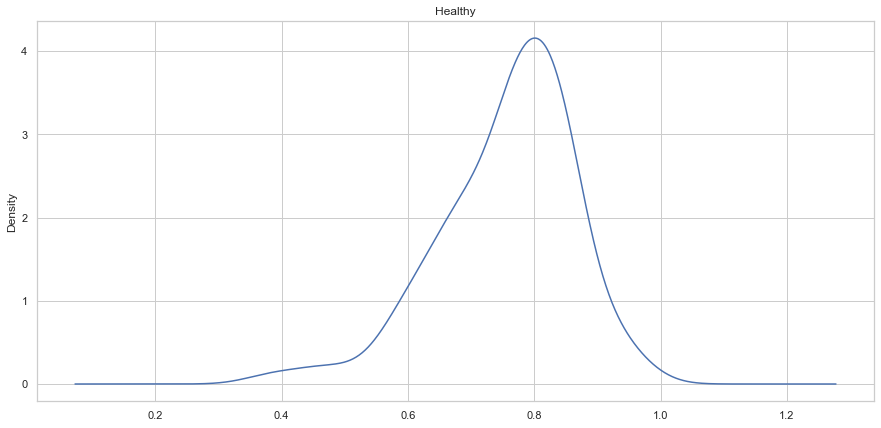

In [285]:
ax = coh[coh['target']=='healthy']['coh_nofilt_fp1_t3'].plot.kde(figsize=[15,7], title='Healthy')

From the density plots we can say that healthy subjects approximate to a gaussian distribution, on the other hand trauma group also looks gaussian, but to a mixture of gaussian since
we can see a small evidence of multimodality

* Box plot

Text(0.5, 1.0, 'Trauma')

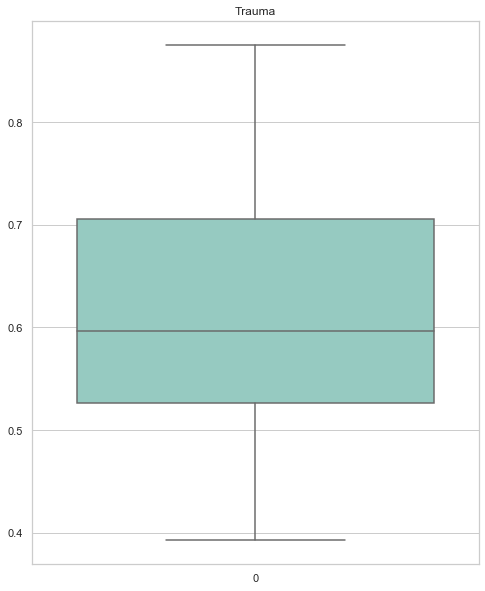

In [314]:
# Specific feature
fig = plt.figure(figsize=[8,10])
ax = sns.boxplot(data=coh[coh['target']=='trauma']['coh_nofilt_fp1_t3'], palette="Set3", orient='v')
plt.title('Trauma')

Text(0.5, 1.0, 'Healthy')

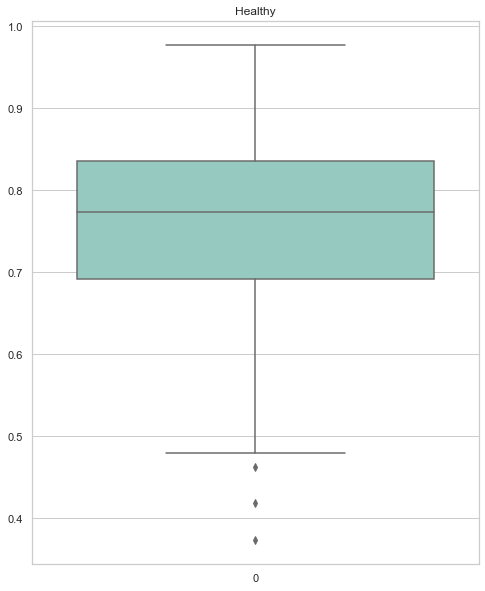

In [316]:
# Specific feature
fig = plt.figure(figsize=[8, 10])
ax = sns.boxplot(data=coh[coh['target']=='healthy']['coh_nofilt_fp1_t3'].values, palette="Set3", orient='v')
plt.title('Healthy')

In [287]:
# Whole set of features
fig = plt.figure(figsize=[20,7])
ax = sns.boxplot(data=coh[coh['target']=='trauma'], palette="Set3", orient='v')
plt.title('Trauma')

Text(0.5, 1.0, 'Trauma')

In [288]:
fig = plt.figure(figsize=[20,7])
ax = sns.boxplot(data=coh[coh['target']=='healthy'], palette="Set3", orient='v')
plt.title('Healthy')

Text(0.5, 1.0, 'Healthy')

From the plots above we can see that most of the coherence features for traumatic injured subjects have lower values than the healthy group. 

This might be our _**first strong biomarker**_ for our task, since coherence can tell us how connected (coherent) different brain regions are<sup>1</sup>. This makes sense because if the brain is injured then connections around that area are lost or weakened, thus coherence would be lower.

[1] Bowyer, S.M. Coherence a measure of the brain networks: past and present. Neuropsychiatr Electrophysiol 2, 1 (2016). https://doi.org/10.1186/s40810-015-0015-7

* **Swarm**

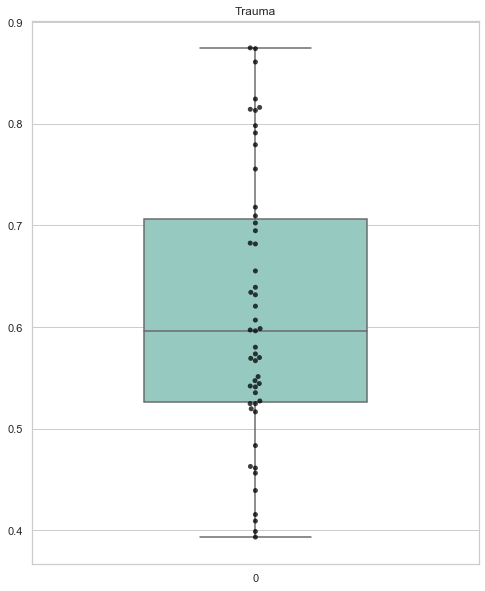

In [342]:
# Specific feature
fig = plt.figure(figsize=[8,10])
bplot = sns.boxplot(data=coh[coh['target']=='trauma']['coh_nofilt_fp1_t3'], palette="Set3", width=0.5, orient='v')
plt.title('Trauma')
 
# add swarmplot
bplot=sns.swarmplot(data=coh[coh['target']=='trauma']['coh_nofilt_fp1_t3'], 
              color='black',
              alpha=0.75)

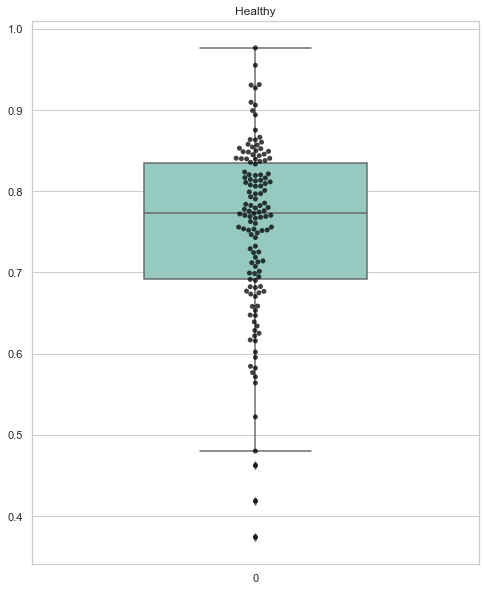

In [343]:
# Specific feature
fig = plt.figure(figsize=[8,10])
bplot = sns.boxplot(data=coh[coh['target']=='healthy']['coh_nofilt_fp1_t3'].values, palette="Set3", width=0.5, orient='v')
plt.title('Healthy')
 
# add swarmplot
bplot=sns.swarmplot(data=coh[coh['target']=='healthy']['coh_nofilt_fp1_t3'].values, 
              color='black',
              alpha=0.75)

**For a set of random features**

Now let's make more general visualization to compare across features and across groups

In [549]:
import random
from scipy.stats import kurtosis, skew

In [583]:
def plot_kde(df, features=[], rand=False, nfeats=5, groups=False):
    
    if len(features)>0:
        rand=False
        
        fig, axs = plt.subplots(nrows=1, ncols=2, figsize=[25,10])

        # 1st group
        for f in range(len(features)):
            sns.kdeplot(df[df['target']=='trauma'][features[f]], ax=axs[0])
        axs[0].set_title(label='Trauma', fontweight="bold", size=20)

        # 2nd group
        for f in range(len(features)):
            sns.kdeplot(df[df['target']=='healthy'][features[f]], ax=axs[1])
        axs[1].set_title(label='Healthy', fontweight="bold", size=20)
        
        # Individual comparison
        if len(features)>1:
            fig, axs = plt.subplots(nrows=2, ncols=len(features), figsize=[26,10])
            plt.suptitle('Individual comparison', size=20)
            # first group
            for f in range(len(features)):
                sns.kdeplot(df[df['target']=='trauma'][features[f]], ax=axs[0, f], color='r', shade=True)

            # second group
            for f in range(len(features)):
                sns.kdeplot(df[df['target']=='healthy'][features[f]], ax=axs[1, f], shade=True)
            for i, ax in enumerate(axs.flat):
                if i==0:
                    ax.set(ylabel='trauma')
                if i==len(features):
                    ax.set(ylabel='healthy')

                if i >= len(features):
                    ax.set(xlabel=features[i-len(features)])
            
    if rand:
        feats = df[df.columns[~df.columns.isin(['fn','target'])]].columns.tolist()
        features = random.choices(feats, k=nfeats)
        
        
        fig, axs = plt.subplots(nrows=1, ncols=2, figsize=[25,10])
        
        # Group
        # 1st group
        for f in range(len(features)):
            sns.kdeplot(df[df['target']=='trauma'][features[f]], ax=axs[0])
        axs[0].set_title(label='Trauma', fontweight="bold", size=20)

        # 2nd group
        for f in range(len(features)):
            sns.kdeplot(df[df['target']=='healthy'][features[f]], ax=axs[1])
        axs[1].set_title(label='Healthy', fontweight="bold", size=20)
        
        
        
        # Individual comparison
        fig, axs = plt.subplots(nrows=2, ncols=nfeats, figsize=[26,10])

        # first group
        for f in range(len(features)):
            sns.kdeplot(df[df['target']=='trauma'][features[f]], ax=axs[0, f], color='r', shade=True)

        # second group
        for f in range(len(features)):
            sns.kdeplot(df[df['target']=='healthy'][features[f]], ax=axs[1, f], shade=True)
        for i, ax in enumerate(axs.flat):
            if i==0:
                ax.set_ylabel(ylabel='trauma', size=18)
            if i==nfeats:
                ax.set_ylabel(ylabel='healthy', size=18)
            
            if i >= nfeats:
                ax.set_xlabel(xlabel=features[i-nfeats], size=13)

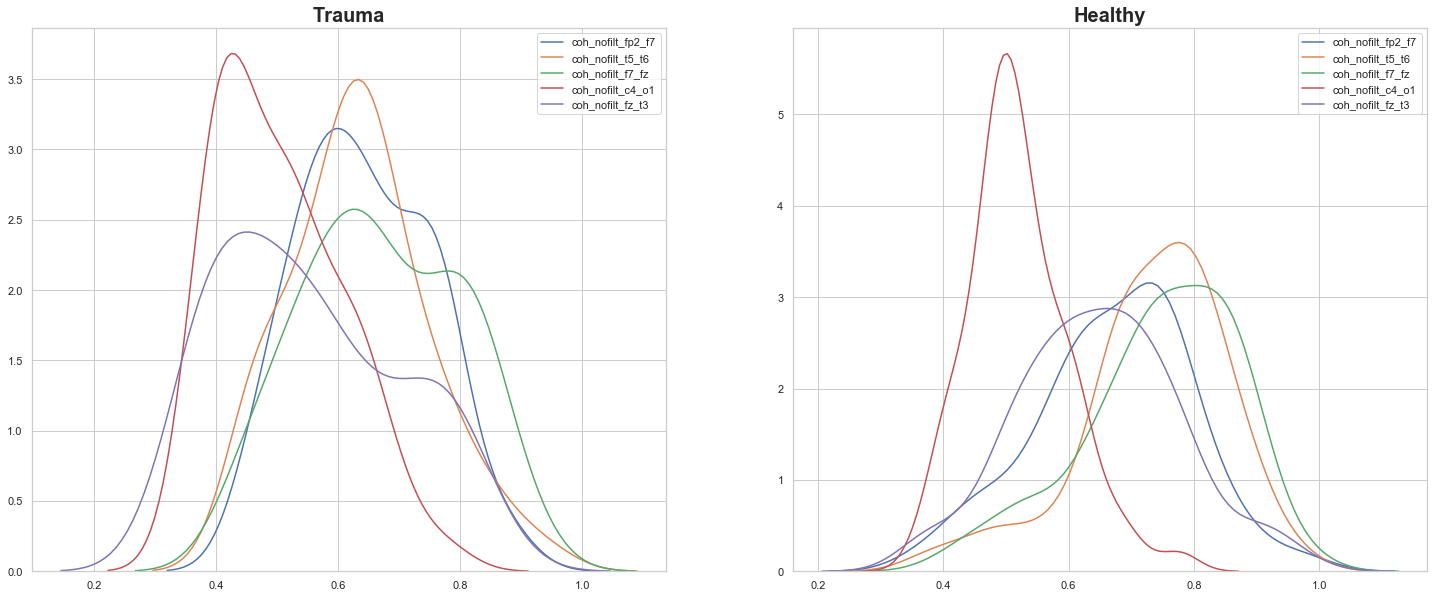

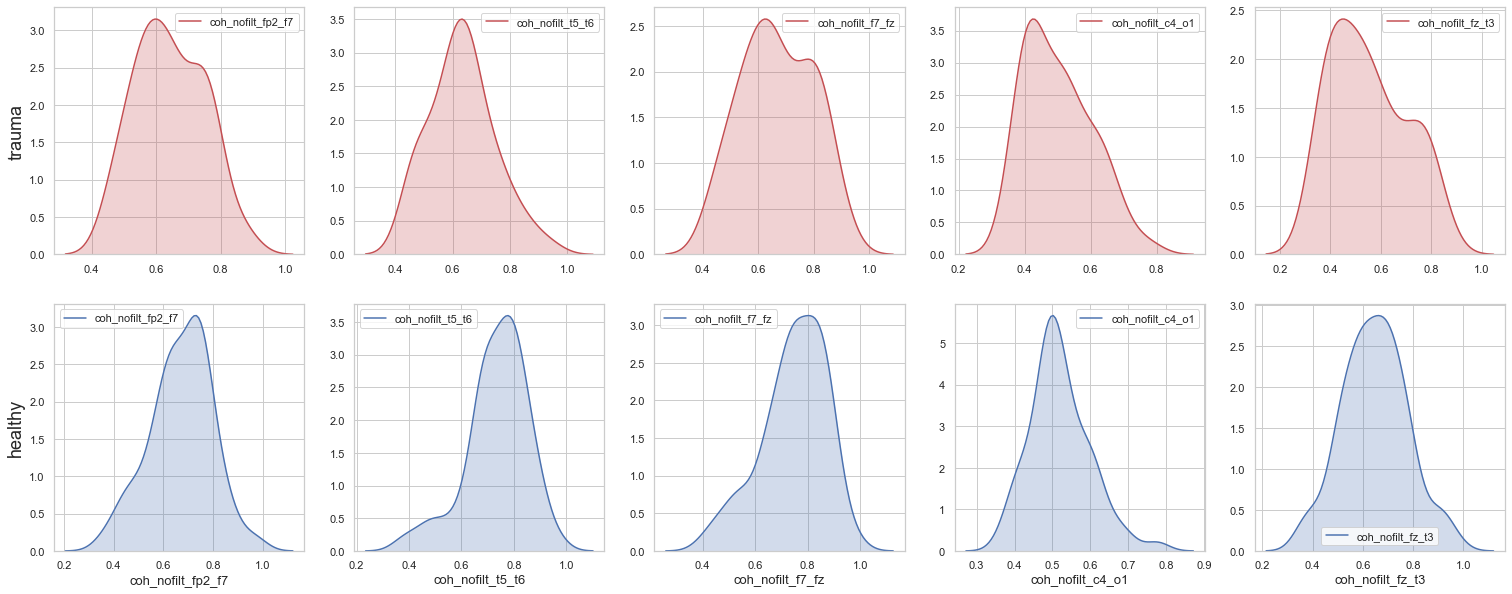

In [584]:
#plot_kde(coh, ['coh_nofilt_fp1_t3', 'coh_nofilt_fz_f8']) # To see specific features
plot_kde(coh, rand=True, nfeats=5)

Densities for zscore features

In [605]:
plot_kde(zcoh, rand=True, nfeats=5)

The pattern we've seen for one random feature repeats for a set of random features

* Kurtosis

In [ ]:
#Interpretation of these curves
#kurtosis(coh[coh['target']=='trauma']['coh_nofilt_c3_p3']), kurtosis(coh[coh['target']=='healthy']['coh_nofilt_c3_p3'])

In [653]:
kcoh = calc_kurtosis(coh)

plt.hist(kcoh['kurt_trauma'])
plt.show()

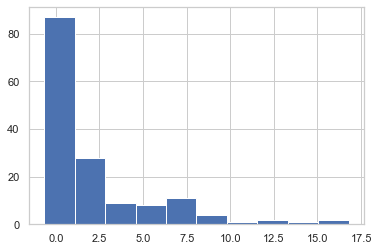

In [654]:
plt.hist(kcoh['kurt_healthy'])
plt.show()

**Kurtosis measure of coherence of alpha band**

In [572]:
coh_alpha = pd.read_csv('ml_data/coh_alpha.csv')
coh_alpha

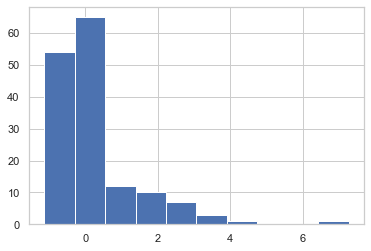

In [573]:
kcoh = calc_kurtosis(coh_alpha)

plt.hist(kcoh['kurt_trauma'])
plt.show()

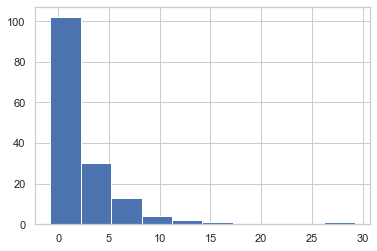

In [574]:
plt.hist(kcoh['kurt_healthy'])
plt.show()

**Kurtosis measure of coherence of beta band**

In [579]:
coh_beta = pd.read_csv('ml_data/coh_theta.csv')
coh_beta

coh_theta_fp1_fp2  coh_theta_fp1_f7  coh_theta_fp1_f3  coh_theta_fp1_fz  \
0             0.975335          0.945432          0.838500          0.698090   
1             0.828407          0.867930          0.928039          0.856615   
2             0.848976          0.867988          0.869446          0.769246   
3             0.924761          0.949899          0.952268          0.800982   
4             0.926431          0.650438          0.743564          0.708278   
..                 ...               ...               ...               ...   
180           0.748319          0.981364          0.995916          0.985685   
181           0.849540          0.894317          0.821739          0.695558   
182           0.863657          0.504105          0.793971          0.414543   
183           0.849763          0.723259          0.608045          0.741281   
184           0.933445          0.604918          0.851274          0.818894   

     coh_theta_fp1_f4  coh_theta_fp1_f8  coh_theta_fp1_t3  coh_theta_fp1_c3  \
0            0.757854          0.932135          0.792530          0.546188   
1            0.726023          0.632050          0.736741          0.669651   
2            0.657296          0.723519          0.643149          0.703682   
3            0.660136          0.775190          0.864806          0.737555   
4            0.651153          0.674678          0.440361          0.454741   
..                ...               ...               ...               ...   
180          0.750744          0.755780          0.738531          0.595210   
181          0.685544          0.766615          0.734129          0.721235   
182          0.750032          0.702930          0.515611          0.404517   
183          0.715108          0.688297          0.789890          0.416730   
184          0.762165          0.420775          0.637107          0.661494   

     coh_theta_fp1_c4  coh_theta_fp1_t4  ...  coh_theta_pz_o1  \
0            0.512091          0.878885  ...         0.686316   
1            0.371007          0.614744  ...         0.562056   
2            0.427382          0.653132  ...         0.646331   
3            0.393930          0.657070  ...         0.788415   
4            0.383648          0.425727  ...         0.698846   
..                ...               ...  ...              ...   
180          0.362963          0.692627  ...         0.671785   
181          0.551905          0.666191  ...         0.751136   
182          0.472533          0.528455  ...         0.755906   
183          0.388957          0.449591  ...         0.876168   
184          0.504774          0.577689  ...         0.849139   

     coh_theta_pz_o2  coh_theta_p4_t6  coh_theta_p4_o1  coh_theta_p4_o2  \
0           0.593641         0.806294         0.772573         0.785368   
1           0.604442         0.676233         0.578879         0.714687   
2           0.451636         0.696066         0.613392         0.645207   
3           0.797132         0.910980         0.771383         0.848664   
4           0.710827         0.821865         0.697771         0.802095   
..               ...              ...              ...              ...   
180         0.622943         0.689365         0.706420         0.769797   
181         0.604702         0.886445         0.803189         0.924521   
182         0.705038         0.844724         0.820149         0.834288   
183         0.775474         0.831264         0.788309         0.807769   
184         0.534515         0.840421         0.678370         0.854211   

     coh_theta_t6_o1  coh_theta_t6_o2  coh_theta_o1_o2                    fn  \
0           0.916223         0.920210         0.963625  b906373005ba09e6.csv   
1           0.831027         0.909348         0.880469  bc8568311c86157d.csv   
2           0.916472         0.897373         0.862487  5c9ca89c610ef553.csv   
3           0.884010         0.943151         0.979470  2a4a9f39f461ddbd.csv   
4           0

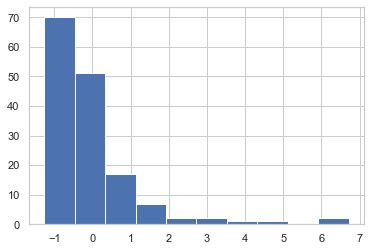

In [580]:
kcoh = calc_kurtosis(coh_beta)

plt.hist(kcoh['kurt_trauma'])
plt.show()

In [581]:
plt.hist(kcoh['kurt_healthy'])
plt.show()

The most significant difference for _kurtosis_ appears for coherence (`coh`) features. On the other hand small difference coherence for alpha band. 
Small difference means that density functions look similar and therefore would not be a key feature to distinguish trauma from healthy subjects

**Relationship between constructed features**

In [615]:
df = zcoh
feats = df[df.columns[~df.columns.isin(['fn','target'])]].columns.tolist()
features = random.choices(feats, k=10)

g = sns.PairGrid(df[features])
g.map_upper(sns.scatterplot)
g.map_lower(sns.kdeplot)
g.map_diag(sns.kdeplot, lw=3, legend=False)

small correlation between features can be observed from the plot above

**Correlation matrix**

In [619]:
corrMatrix = df[features].corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()

Now let's continue with another set of features and different diagram

**Envelope**

In [635]:
def plot_box(df, features=None):
    if features==None:
        fig, axs = plt.subplots(nrows=2, ncols=1, figsize=[25,12])
        sns.boxplot(data=df[df['target']=='trauma'], palette="Set3", orient='v', ax=axs[0])
        axs[0].set_ylabel(ylabel='Trauma', size=18)
        
        sns.boxplot(data=df[df['target']=='healthy'], palette="Set3", orient='v', ax=axs[1])
        axs[1].set_ylabel(ylabel='Healthy', size=18)
    else:
        fig, axs = plt.subplots(nrows=2, ncols=1, figsize=[25,12])
        sns.boxplot(data=df[df['target']=='trauma'][features], palette="Set3", orient='v', ax=axs[0])
        axs[0].set_ylabel(ylabel='Trauma', size=18)

        sns.boxplot(data=df[df['target']=='healthy'][features], palette="Set3", orient='v', ax=axs[1])
        axs[1].set_ylabel(ylabel='Healthy', size=18)
        plt.title('Trauma')
    

In [623]:
env = pd.read_csv('ml_data/env.csv')
env.head()

env_nofilt_fp1_fp2  env_nofilt_fp1_f7  env_nofilt_fp1_f3  \
0            0.963666           0.902723           0.821742   
1            0.648686           0.688071           0.740198   
2            0.636934           0.596891           0.510969   
3            0.827225           0.870244           0.854873   
4            0.753755           0.421308           0.430955   

   env_nofilt_fp1_fz  env_nofilt_fp1_f4  env_nofilt_fp1_f8  env_nofilt_fp1_t3  \
0           0.724366           0.764587           0.889054           0.578062   
1           0.751433           0.543396           0.380360           0.399781   
2           0.536518           0.219991           0.372753           0.410429   
3           0.702335           0.446045           0.532413           0.624277   
4           0.384583           0.351538           0.516560           0.083406   

   env_nofilt_fp1_c3  env_nofilt_fp1_c4  env_nofilt_fp1_t4  ...  \
0           0.162673           0.299755           0.706752  ...   
1           0.390548           0.181533           0.255338  ...   
2           0.248559           0.007308           0.143143  ...   
3           0.253638           0.075979           0.296740  ...   
4           0.097434           0.065022           0.103120  ...   

   env_nofilt_pz_o1  env_nofilt_pz_o2  env_nofilt_p4_t6  env_nofilt_p4_o1  \
0          0.413693          0.350369          0.495089          0.507648   
1          0.226062          0.294402          0.451108          0.228507   
2          0.247631          0.156015          0.273398          0.141925   
3          0.482710          0.459952          0.708362          0.454721   
4          0.383193          0.407918          0.692571          0.429720   

   env_nofilt_p4_o2  env_nofilt_t6_o1  env_nofilt_t6_o2  env_nofilt_o1_o2  \
0          0.524280          0.779741          0.795956          0.928130   
1          0.453191          0.542916          0.810411          0.692025   
2          0.242507          0.483355          0.665560          0.539020   
3          0.642554          0.593104          0.799930          0.900311   
4          0.659542          0.585365          0.866805          0.796739   

                     fn  target  
0  b906373005ba09e6.csv  trauma  
1  bc8568311c86157d.csv  trauma  
2  5c9ca89c610ef553.csv  trauma  
3  2a4a9f39f461ddbd.csv  trauma  
4  a4c28a88c78ef3f5.csv  trauma  

[5 rows x 155 columns]

In [637]:
# Box plot of envelope for whole dataset
plot_box(env)

Here we can see outliers for the healthy subjects in the lower quartiles.
I can't say what exactly could mean

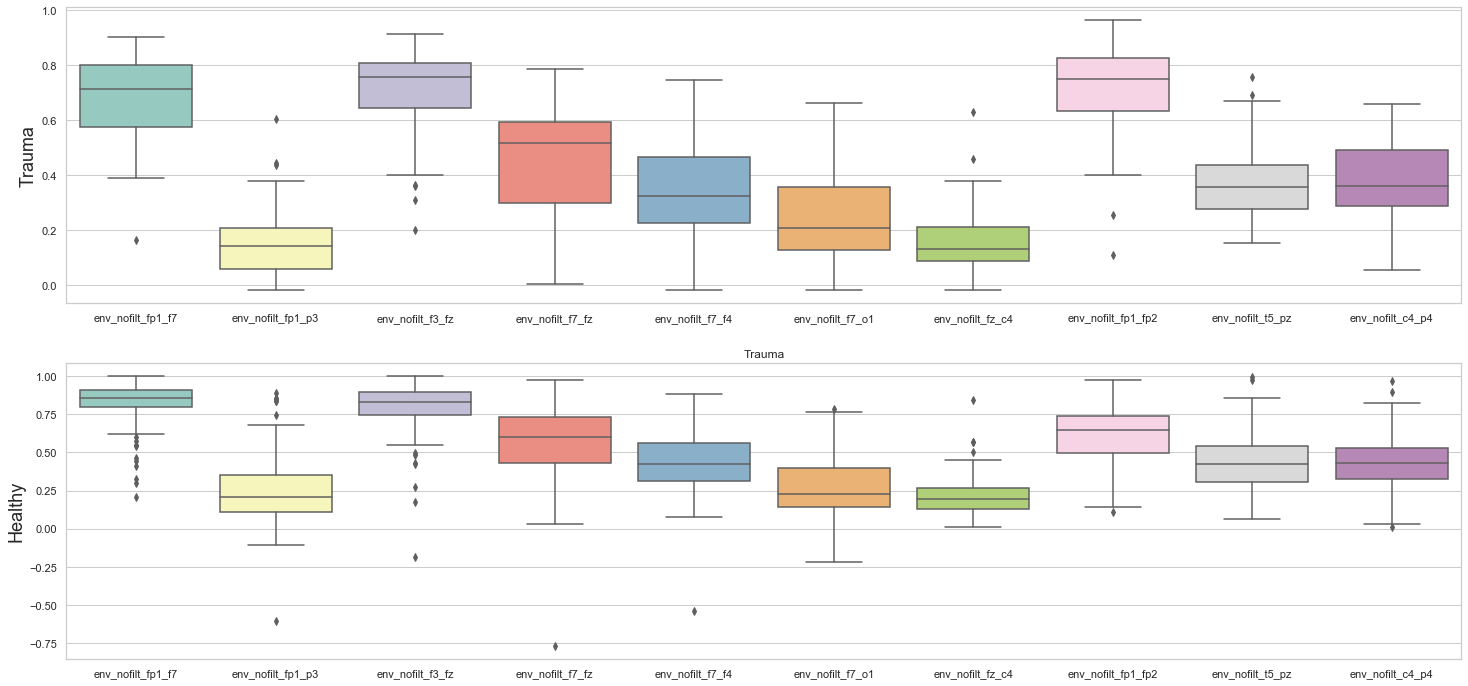

In [636]:
 # Box plot of envelope for a subset of features
df = env
feats = df[df.columns[~df.columns.isin(['fn','target'])]].columns.tolist()
features = random.choices(feats, k=10)

plot_box(env, features)

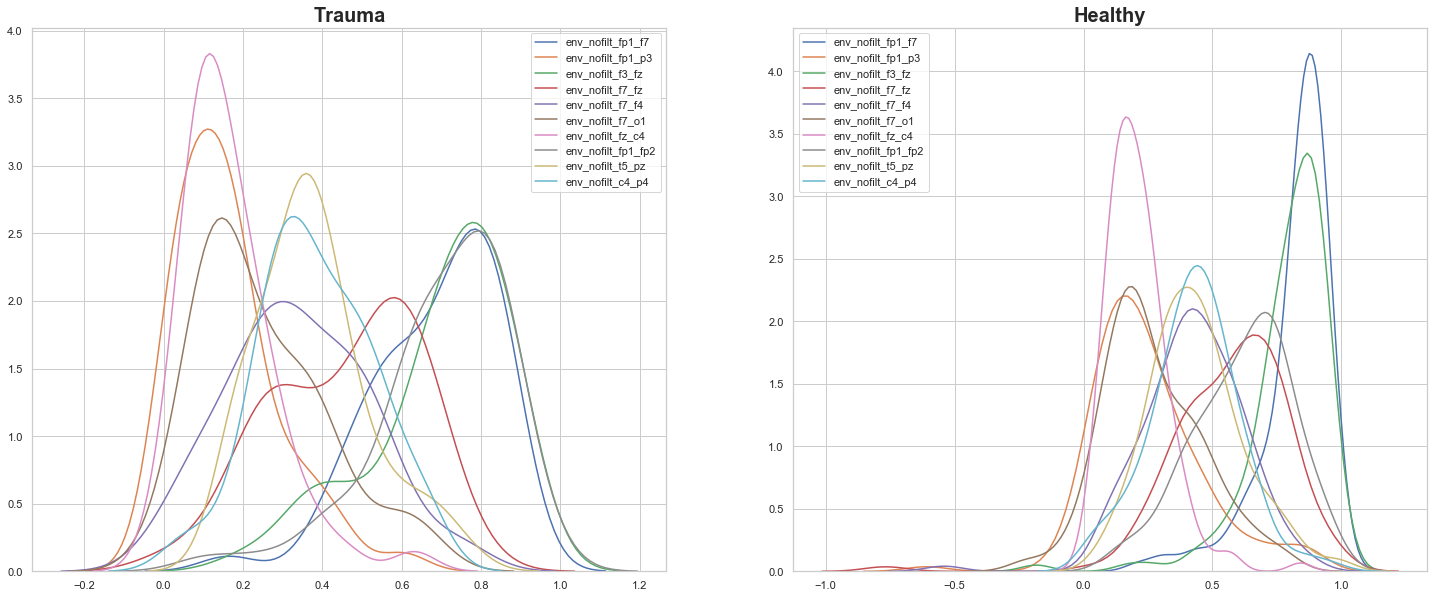

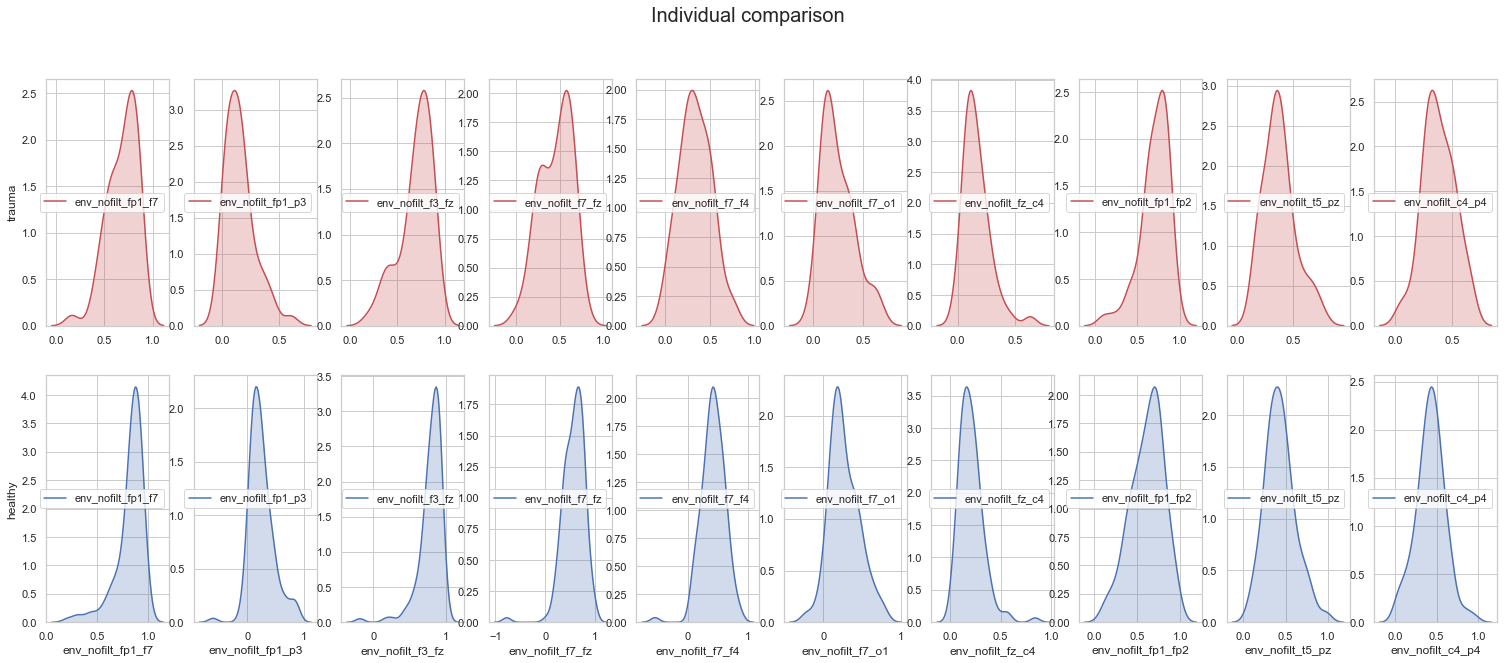

In [639]:
plot_kde(df, features)

**Bands**

In [643]:
band = pd.read_csv('ml_data/bands.csv')
band

bands_alpha_fp1  bands_beta_fp1  bands_theta_fp1  bands_gamma_fp1  \
0          26.112841        7.050809         5.260583         0.526858   
1          20.082857       18.806124        11.013583         0.194203   
2          66.473926       71.578318        15.532426         4.234422   
3         107.596254       24.001618        66.554171         0.183359   
4           5.822616        9.104380         9.943178         0.882444   
..               ...             ...              ...              ...   
180        28.132170        7.793856         8.443856         0.422198   
181         6.140002       12.911890         8.555494         1.857695   
182         6.660207        5.060272         2.278031         0.494373   
183        47.073551        5.786831         4.878320         0.880660   
184        22.286345       28.674178        21.439701         7.625312   

     bands_alpha_fp2  bands_beta_fp2  bands_theta_fp2  bands_gamma_fp2  \
0          16.885092        5.154640         3.491466         0.366738   
1          18.354747       16.704967        10.673457         0.141863   
2          59.742391       14.430980        10.727934         1.782964   
3         116.344467       25.653328        67.833714         0.174889   
4           5.785865        9.241420        11.181901         0.983537   
..               ...             ...              ...              ...   
180        11.035386        2.474638         3.165295         0.134047   
181         2.699647        4.601470         4.629223         0.613731   
182         9.507809        8.965112         4.737308         0.932711   
183        46.768414        5.364641         4.561241         0.665669   
184        15.220710       15.425340         8.953403         2.978777   

     bands_alpha_f7  bands_beta_f7  ...  bands_alpha_o1  bands_beta_o1  \
0         23.428561       7.773904  ...       22.853672      11.627172   
1         20.845891      15.760247  ...       85.863173      29.719480   
2         51.984387      24.725416  ...       51.235402      48.481772   
3         89.849134      23.994045  ...       79.578831      23.801003   
4          5.724653       6.185249  ...       14.783130       9.685461   
..              ...            ...  ...             ...            ...   
180       25.323538       7.411689  ...      107.894848      19.536825   
181        5.953751      10.524671  ...       14.857729      13.522882   
182        9.047871       6.364515  ...       25.829750       8.530797   
183       36.074748       7.025010  ...      233.941636      10.700762   
184       41.654698      42.860494  ...       62.427705      44.439914   

     bands_theta_o1  bands_gamma_o1  bands_alpha_o2  bands_beta_o2  \
0         10.003746        0.787576       23.357009      11.553152   
1         28.688580        0.167025       85.566435      31.411912   
2         12.941790       19.754951       42.567940      20.405893   
3         59.177488        0.116438       73.076297      23.191103   
4          6.656733        0.481252       15.961496       6.826721   
..              ...             ...             ...            ...   
180       19.703482        0.758138      101.326238      17.706730   
181        6.412821        1.253049        7.403476       9.081738   
182        7.058280        0.722493       21.754166       6.207193   
183        6.594222        0.756009      235.666182      13.533132   
184       19.450066        7.060864       97.834589      38.362795   

     bands_theta_o2  bands_gamma_o2                    fn   target  
0         10.253875        0.734024  b906373005ba09e6.csv   trauma  
1         29.610265        0.191433  bc8568311c86157d.csv   trauma  
2         10.546612        5.912293  5c9ca89c610ef553.csv   trauma  
3         56.188396        0.124746  2a4a9f39f461ddbd.csv   trauma  
4          4.765705        0.168879  a4c28a88c78ef3f5.csv   trauma  
..              ...             ...                   ...      ...  
180       16.3

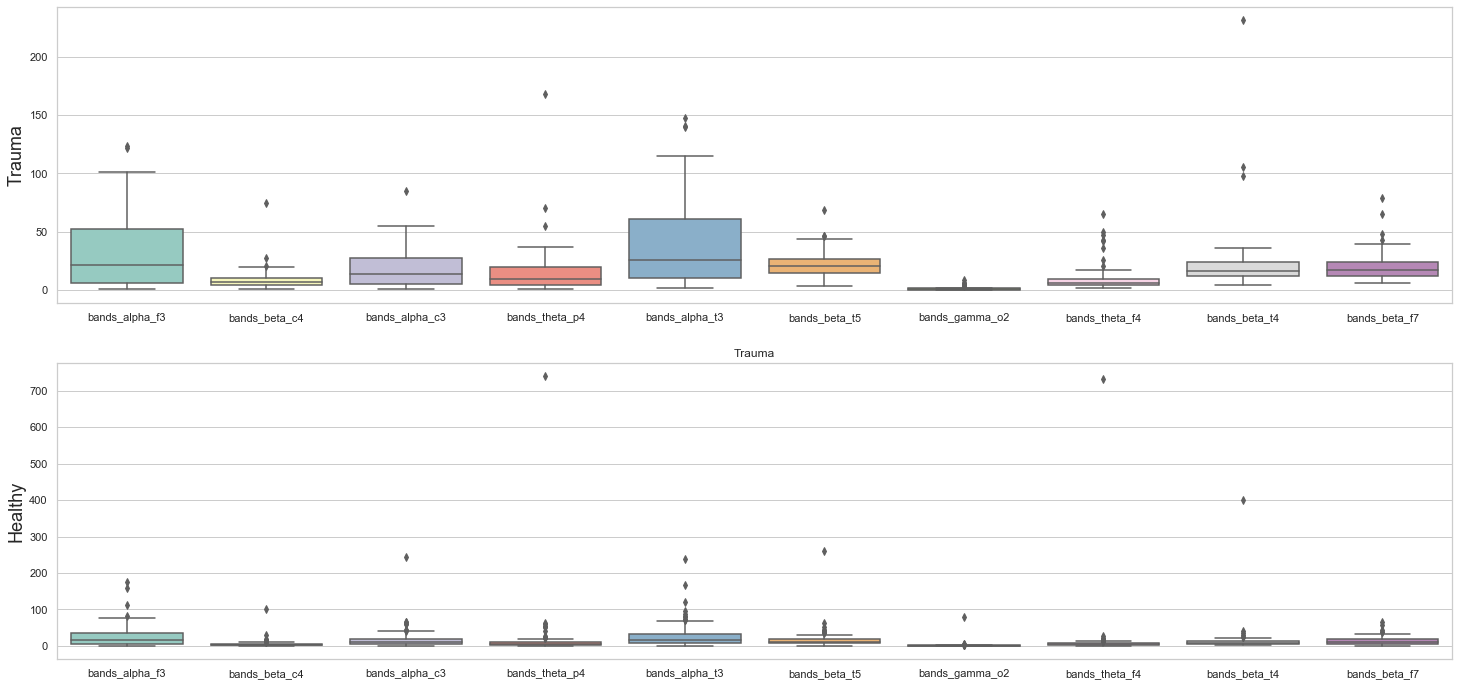

In [645]:
df = band
feats = df[df.columns[~df.columns.isin(['fn','target'])]].columns.tolist()
features = random.choices(feats, k=10)

plot_box(df, features)

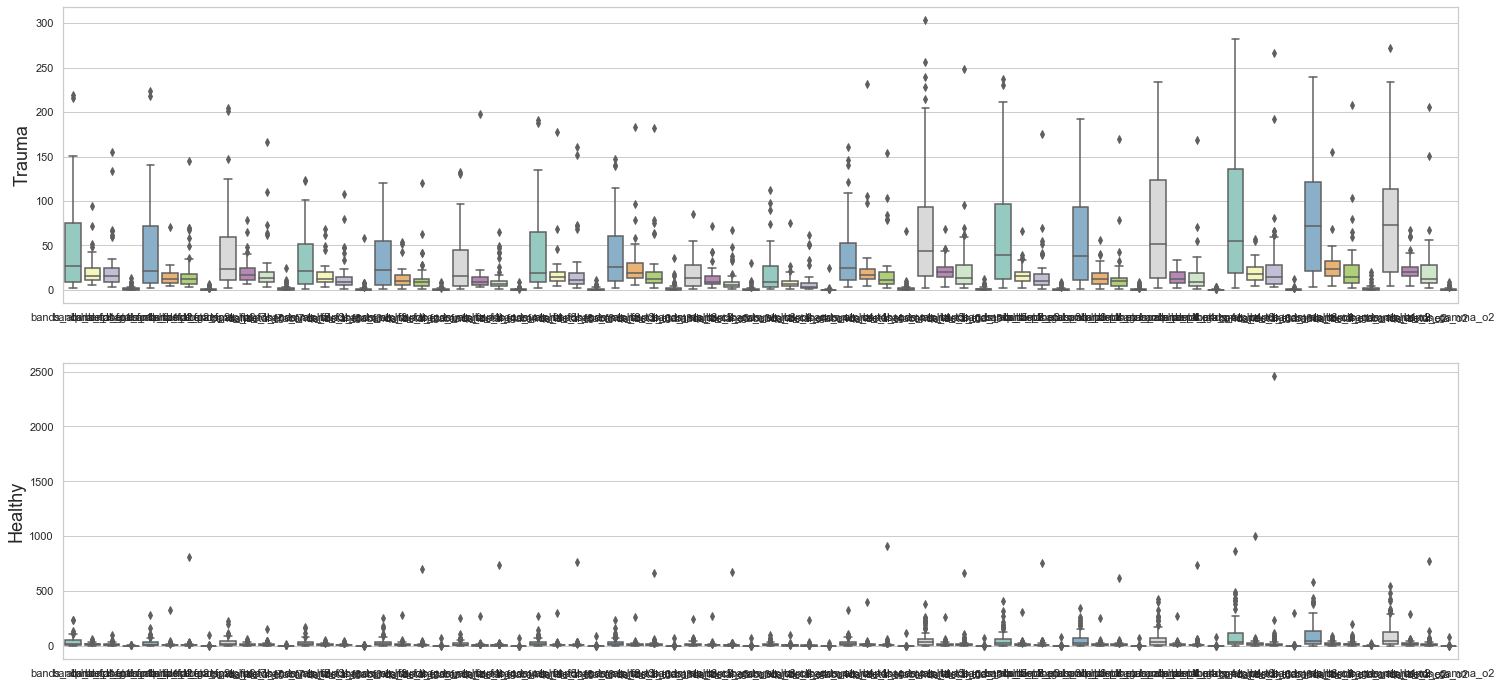

In [646]:
plot_box(df)

Here there is also huge values in the band features for healthy patients.

It will be important to remove these outliers for the ML part

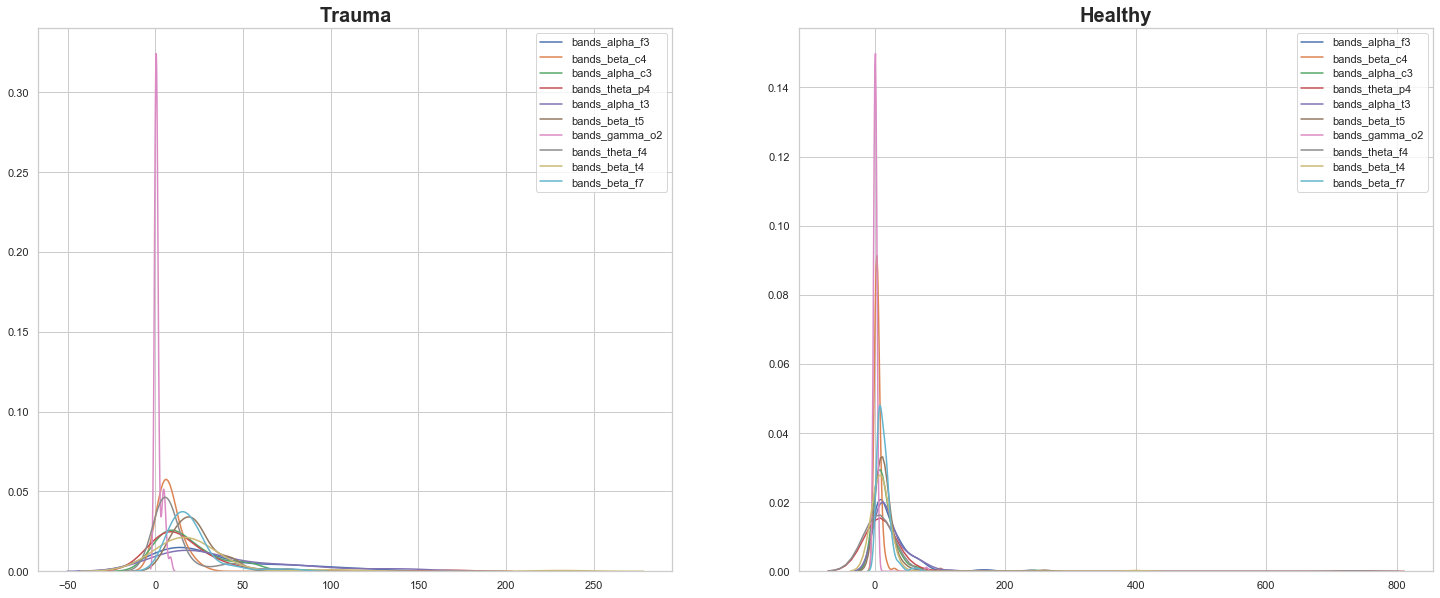

In [647]:
plot_kde(df, features)

**Psi**

In [648]:
psi = pd.read_csv('ml_data/psi.csv')
psi

psi_alpha_fp2_fp1  psi_alpha_f7_fp1  psi_alpha_f7_fp2  psi_alpha_f3_fp1  \
0            -0.155942          0.062880          0.760726         -0.260105   
1             0.574347         -0.375929         -1.383177         -2.111167   
2             0.171039          0.381476          0.265420         -0.096341   
3             0.163513         -0.085166         -0.470888         -0.215526   
4            -0.974355          0.351962         -0.002172         -0.021860   
..                 ...               ...               ...               ...   
180          -0.293059         -0.085798          0.267424         -0.004907   
181          -0.432185         -0.075620          0.297946          0.270616   
182          -0.337202          0.848993          2.183051          0.853710   
183           0.004096          0.527729          0.558008          0.108481   
184          -0.430929         -2.129104         -0.921943         -2.331676   

     psi_alpha_f3_fp2  psi_alpha_f3_f7  psi_alpha_fz_fp1  psi_alpha_fz_fp2  \
0           -0.225492        -0.419948         -0.161844          0.185443   
1           -2.400723        -0.593698         -1.342878         -1.001143   
2            1.163707         0.130452          1.088576          1.196557   
3           -1.527130        -0.019754          0.891796          0.105420   
4            0.272651         0.618353         -0.710426         -0.650729   
..                ...              ...               ...               ...   
180          0.286628         0.030352          0.100267          0.669892   
181          1.619737         1.299050          0.762864          1.388705   
182          3.486499         0.053590          0.577861          1.996740   
183         -0.616467         0.014752         -0.004896         -0.145580   
184         -0.858708         1.254902         -5.969604         -3.011265   

     psi_alpha_fz_f7  psi_alpha_fz_f3  ...  psi_alpha_o2_c4  psi_alpha_o2_t4  \
0          -0.597900        -0.022164  ...         1.139019         0.161162   
1           0.109839         0.610778  ...         0.180625        -2.210631   
2           1.362480         0.624630  ...         0.857226         0.921500   
3           1.642005         1.283031  ...        -0.557241        -0.140675   
4           0.512792         0.282943  ...         3.881311         4.463736   
..               ...              ...  ...              ...              ...   
180         0.545988         0.256094  ...         2.314810         0.436194   
181         1.520015         0.514908  ...        -0.211394         4.874666   
182        -2.000976        -2.257323  ...        -4.817190         0.418351   
183        -1.274751        -0.231333  ...         2.917813         0.728432   
184        -5.622864        -3.362427  ...        -1.334246        -1.417780   

     psi_alpha_o2_t5  psi_alpha_o2_p3  psi_alpha_o2_pz  psi_alpha_o2_p4  \
0           0.343749         1.730590         1.753386         0.614453   
1          -1.151112        -4.492981        -1.780906         1.072070   
2           0.977153        -1.578377        -1.981732         0.647662   
3          -1.310494         1.707771         0.133473         0.153390   
4           0.579768         2.091910         2.019134         4.555991   
..               ...              ...              ...              ...   
180         0.685202        -1.034235         0.343972         0.088445   
181         4.768721        -1.390298        -1.161819         0.014592   
182        -0.073473        -1.036244        -0.048754        -3.744113   
183         0.273883         0.256836        -1.261513        -0.417766   
184        -1.452185        -0.912683        -0.782838        -0.382366   

     psi_alpha_o2_t6  psi_alpha_o2_o1                    fn   target  
0          -0.426888         0.021381  b906373005ba09e6.csv   trauma  
1          -0.566028        -0.326627  bc8568311c86157d.csv   trauma  
2           0.539165        -0.1

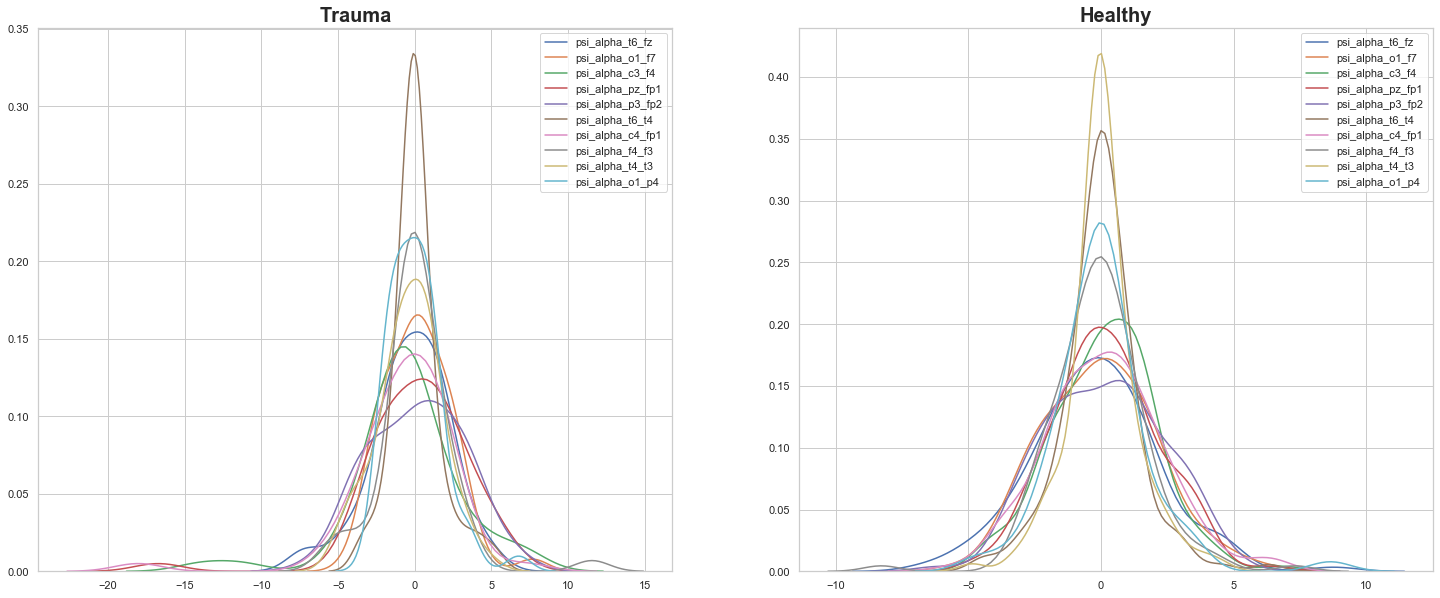

In [649]:
df = psi
feats = df[df.columns[~df.columns.isin(['fn','target'])]].columns.tolist()
features = random.choices(feats, k=10)

plot_kde(df, features)

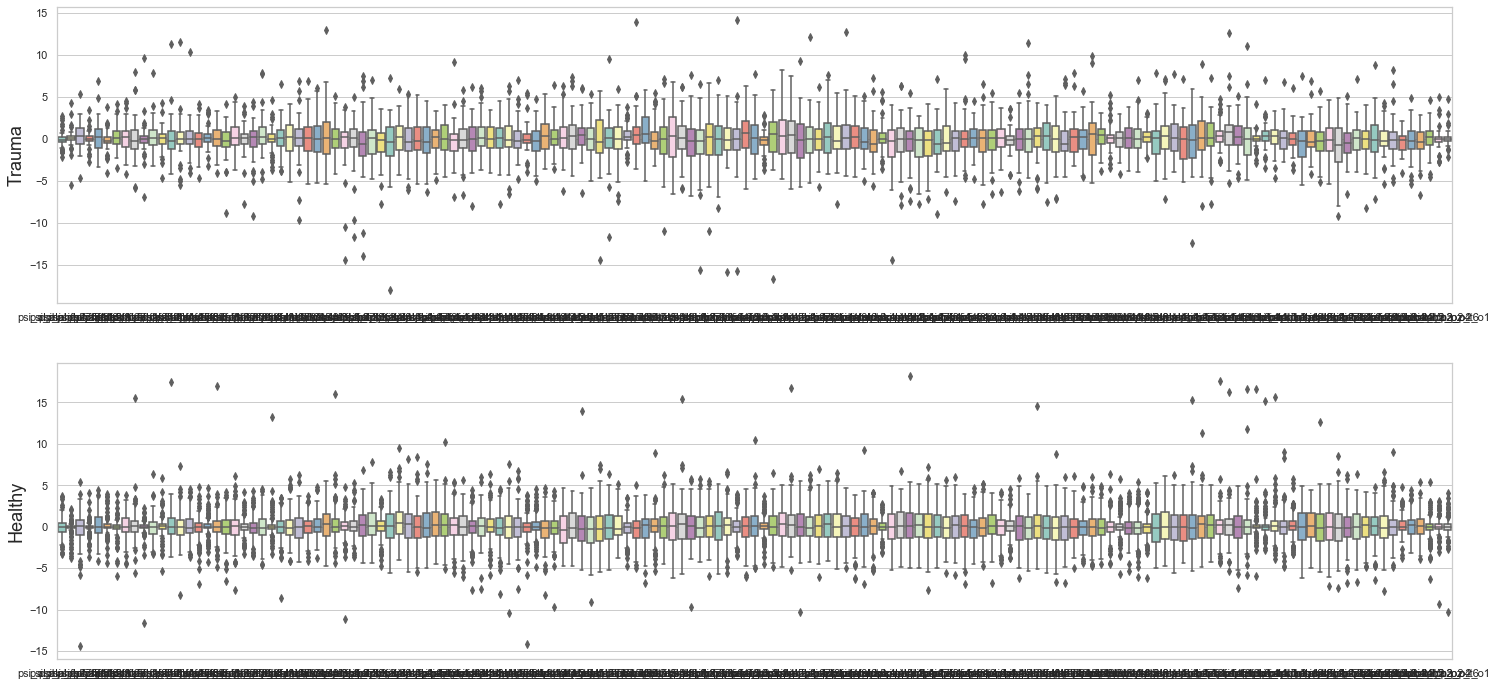

In [650]:
plot_box(df)

At first glance it might be a feature that doesn't help to the detection of helthy and trauma groups
in this case since psi values are centered around zero and plots for both groups looks similar, it would be convenient to measure its standard deviation.